In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from ml import GaussianKernel, ComputationMode, load_kernels_dict
from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries
from stochastic import (EulerMaruyama, ConstantDiffusionMultivariate, SpatialDifferenceDriftMultivariate, 
                        SpatialDiffusionUnivariate, SpatialDriftMultivariate, SpatialNearestDriftMultivariate)

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [5]:
# filter data before 2004 (missing dates in 2003) and beyond 2021
df = df_raw.query("year >= 2004 & year <= 2020")

### Univariate timeseries

In [ ]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

In [ ]:
s_1.plot_ts()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

In [ ]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [ ]:
a = s_1.drift.mean["drift_1"]
a = a.reindex(np.arange(0, a.index.max() + 20)).fillna(0)
b = s_1.diffusion.mean["diffusion_1"]
b = b.reindex(np.arange(0, b.index.max() + 20)).fillna(0)

x_df = s_1.df[(s_1.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[0]

In [ ]:
drift = SpatialDriftMultivariate(df=a.to_frame())
diffusion = SpatialDiffusionUnivariate(df=b.to_frame())

em_1 = EulerMaruyama(num_sim=1000, period=24*6, delta_t=1, nu=0, drift=drift, diffusion=diffusion)

In [ ]:
sim_df = em_1.simulate(x0=np.array([x_0]), random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[:,  :em_1.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Multivariate  timeseries $D_{1}^i(x)$ 

In [6]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

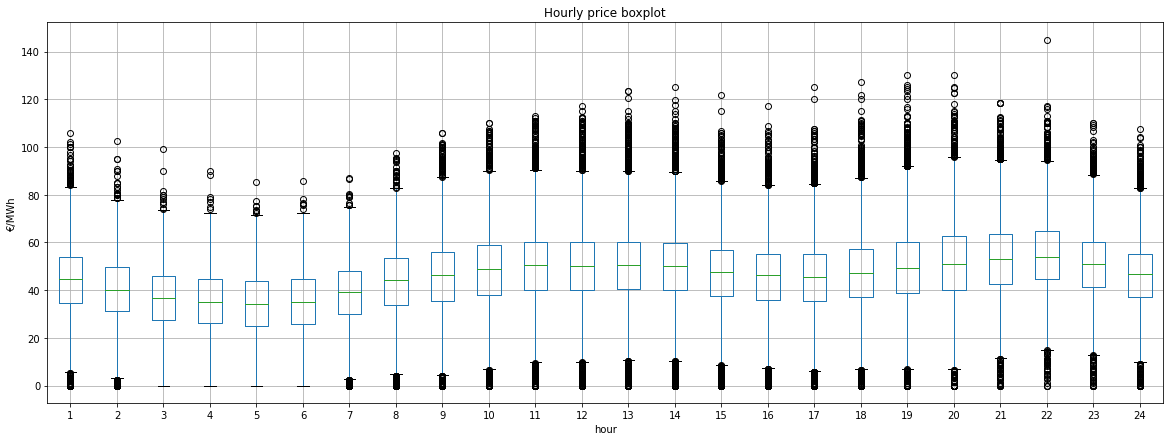

In [7]:
s.plot_hourly_boxplot()

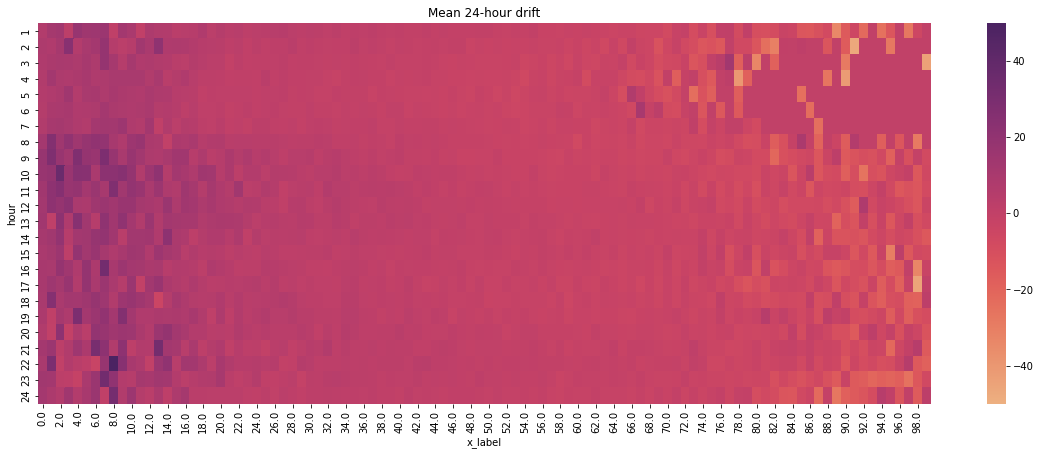

In [8]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-50, vmax=50)
ax.set_title("Mean 24-hour drift")
fig.show()

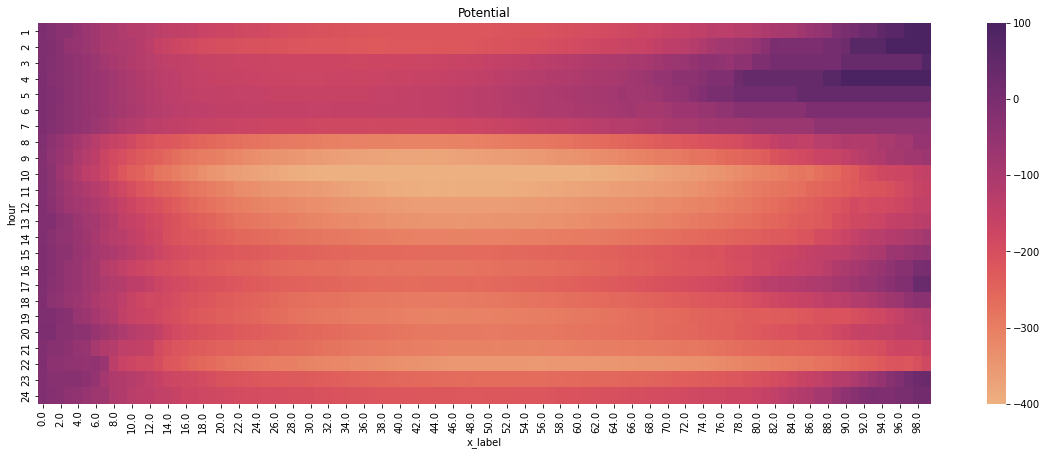

In [9]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-400, vmax=100)
ax.set_title("Potential")
fig.show()

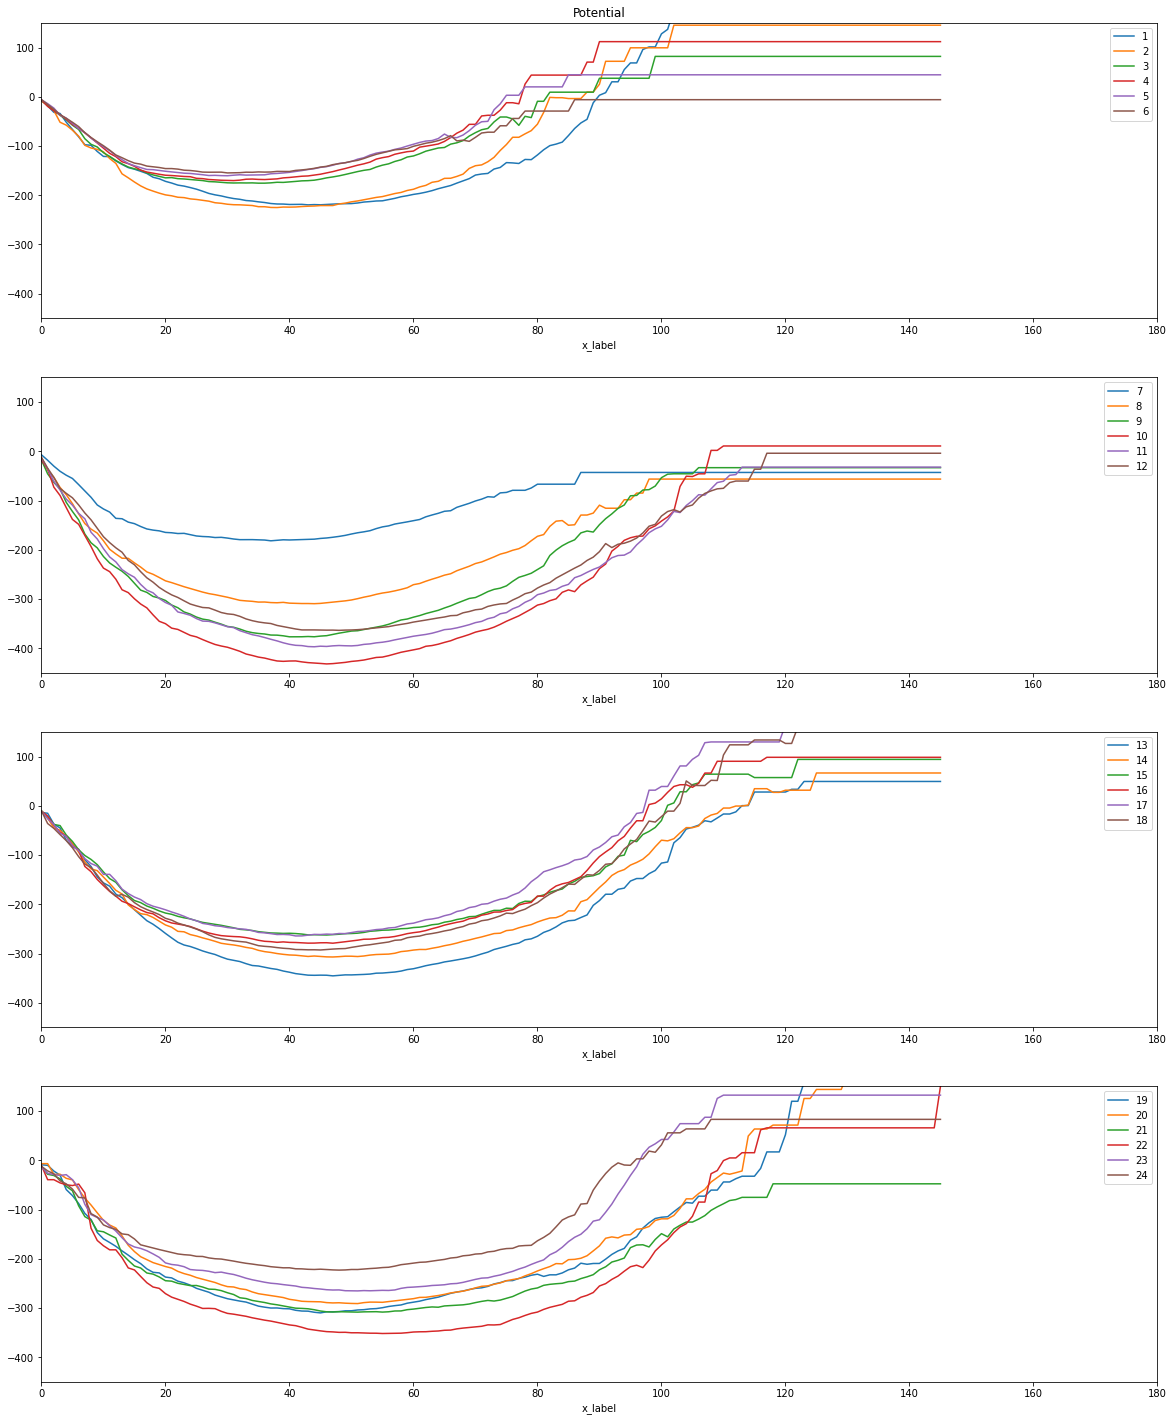

In [10]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 180)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

Text(0.1, 0.5, 'potential $[(€/MWh)^{2}/day]$')

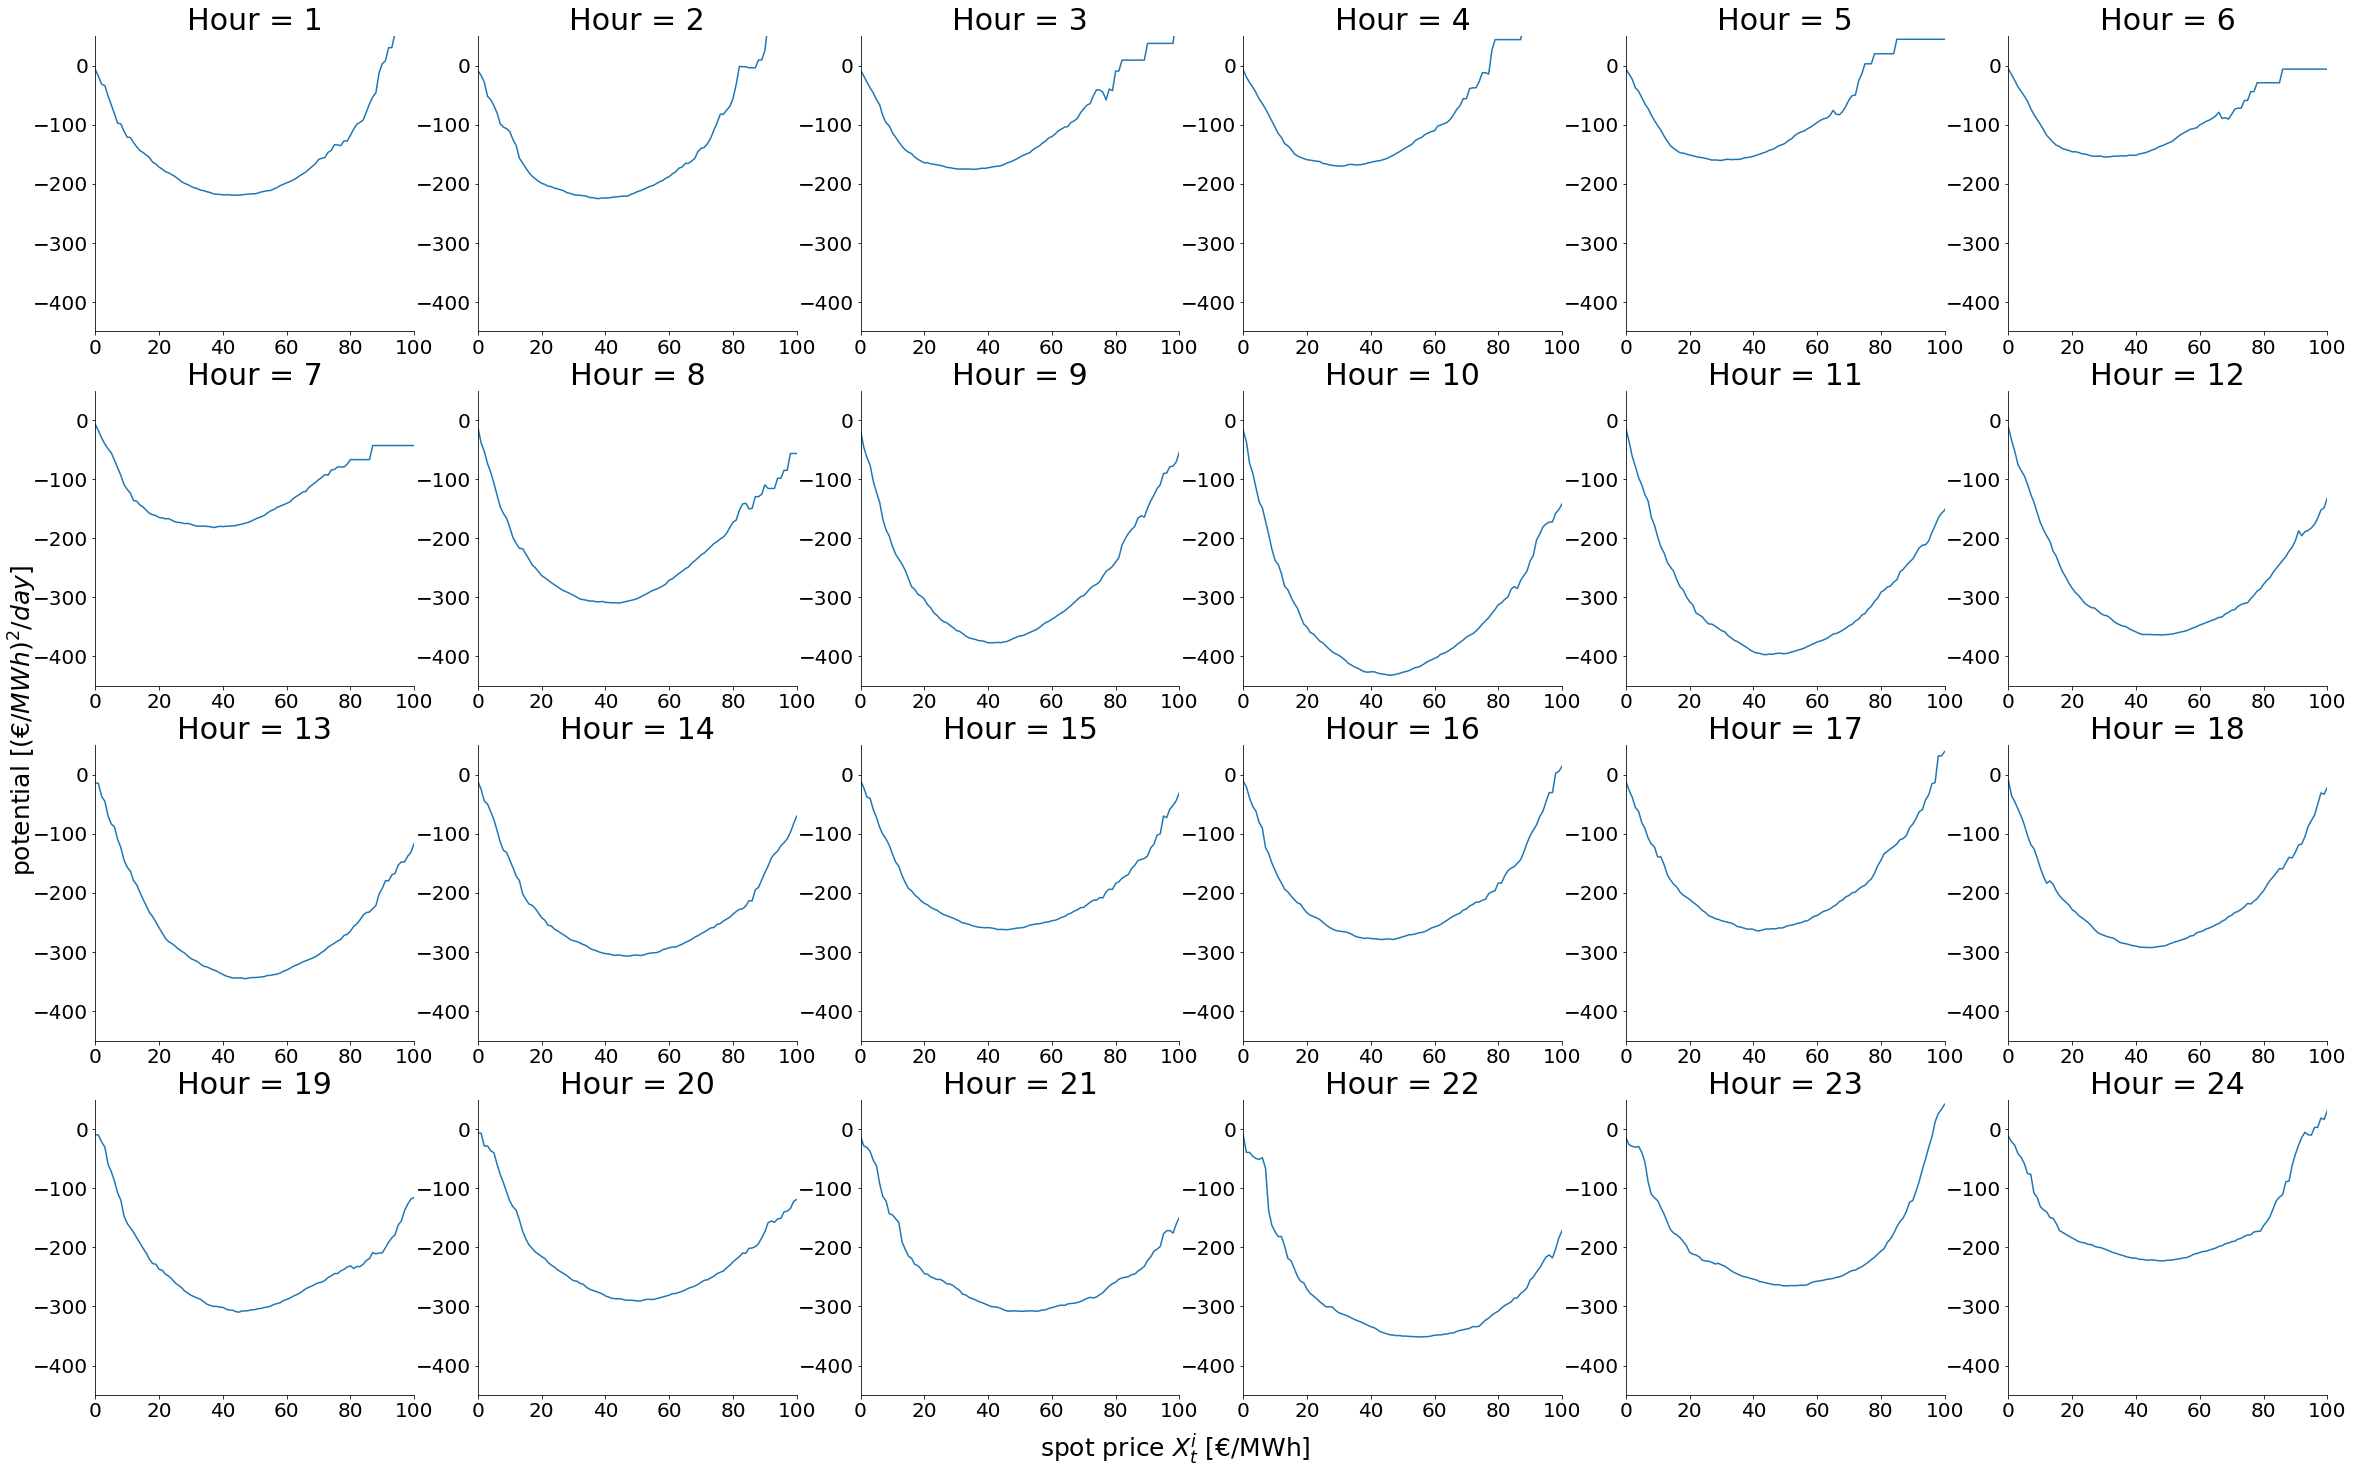

In [11]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(0, 100)
        ax.set_ylim(-450, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price $X_{t}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

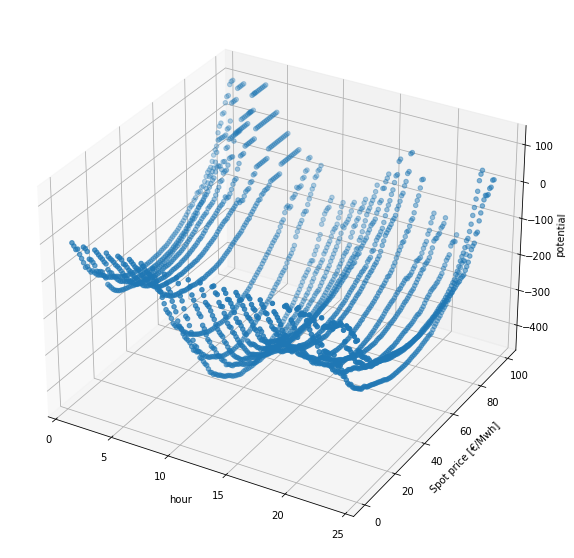

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.iloc[:, :100].stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("Spot price [€/Mwh]")
ax.set_zlabel("potential")
fig.show()

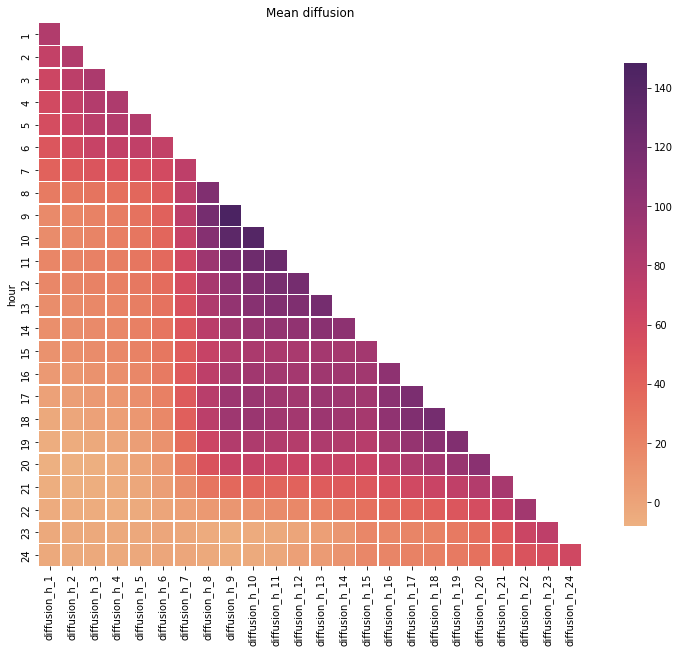

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

In [14]:
s.diffusion_matrix

diffusion_h_1  diffusion_h_2  diffusion_h_3  diffusion_h_4  \
hour                                                               
1         81.153554      69.260902      62.746485      58.989593   
2         69.260902      80.093343      74.214832      69.028710   
3         62.746485      74.214832      84.639043      79.715300   
4         58.989593      69.028710      79.715300      83.361982   
5         55.560106      65.103207      75.567348      79.453230   
6         49.153761      57.823344      66.556894      69.817813   
7         40.512962      46.103269      49.491823      51.363660   
8         25.546133      27.702698      29.747204      32.229215   
9         16.273927      18.385630      21.056457      24.252401   
10        15.202653      17.159991      19.788168      22.739272   
11        18.625293      19.947669      21.659153      23.449772   
12        18.204092      19.324323      21.018450      22.565545   
13        14.467144      15.853466      17.434968      18.973098   
14        13.188507      14.406904      16.040144      17.605638   
15        11.455806      13.023015      15.107596      16.933486   
16         6.462725       8.550729      11.511964      13.258345   
17         1.384786       3.646038       6.702688       8.313668   
18        -3.383648      -1.527342       1.555389       2.999545   
19        -5.413833      -5.100895      -3.033454      -1.441577   
20        -7.348350      -7.824876      -6.913914      -4.365838   
21        -6.416883      -6.722507      -6.371568      -4.931762   
22        -4.456553      -5.150232      -5.315499      -5.648797   
23        -3.159316      -3.330716      -3.199484      -3.358279   
24        -3.199435      -3.915601      -3.465823      -3.351045   

      diffusion_h_5  diffusion_h_6  diffusion_h_7  diffusion_h_8  \
hour                                                               
1         55.560106      49.153761      40.512962      25.546133   
2         65.103207      57.823344      46.103269      27.702698   
3         75.567348      66.556894      49.491823      29.747204   
4         79.453230      69.817813      51.363660      32.229215   
5         80.517675      71.269402      54.544249      37.708817   
6         71.269402      70.039787      58.501032      46.342198   
7         54.544249      58.501032      73.149565      74.191458   
8         37.708817      46.342198      74.191458     113.129790   
9         30.693211      41.492407      74.313008     120.015697   
10        28.691538      38.381239      67.695427     110.212220   
11        28.573027      36.189937      59.962320      94.812222   
12        27.384948      34.387429      55.805145      86.749644   
13        23.847021      31.137468      52.534773      82.887886   
14        22.260783      29.175096      48.476270      75.170911   
15        21.345984      27.922311      44.979205      67.420897   
16        18.191096      25.920550      46.678631      73.289980   
17        13.743423      22.464661      46.335158      76.643047   
18         8.545607      17.549203      42.237507      74.957706   
19         3.454625      11.668504      33.829901      63.283517   
20        -0.268968       7.358796      26.139325      51.121012   
21        -2.125046       3.418934      14.608068      28.974632   
22        -4.065280      -0.836932       3.023719       7.356644   
23        -2.645352      -1.240321      -1.907225      -4.321440   
24        -2.564705      -1.270348      -1.674821      -3.272592   

      diffusion_h_9  diffusion_h_10  ...  diffusion_h_15  diffusion_h_16  \
hour                                 ...                                   
1         16.273927       15.202653  ...       11.455806        6.462725   
2         18.385630       17.159991  ...       13.023015        8.550729   
3         21.056457       19.788168  ...       15.107596       11.511964   
4         24.252401       22.739272  ...       16.933486       13.258345   
5         30

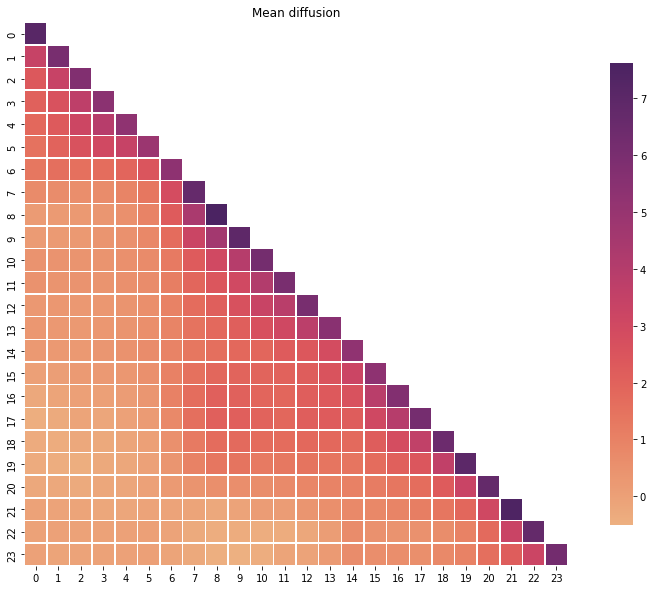

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.sqrt_diff_matrix, dtype=bool), k=1)
sns.heatmap(s.sqrt_diff_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^i(x)$ and diagonal $D_{2}^{ii}$

In [22]:
def plot_simulation(sim_df: pd.DataFrame, 
                    actual_df: pd.DataFrame, 
                    num_sim_show: int = 0,
                    quantile_regions: bool = True,
                    ymax: float = None,
                    title: str = ""
                   ):
    
    fig, ax = plt.subplots(1,1, figsize=(15, 10))
    if num_sim_show > 0:
        sim_df.iloc[24:, : num_sim_show].plot(alpha=0.05, ax=ax, legend=False)
    sim_df.mean(axis=1).plot(lw=1.5, color="blue", ax=ax)
    actual_df.reset_index()["spain"].plot(lw=1.5, color="black", ax=ax)
    intervals_df = sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1)
    if quantile_regions:
        ax.fill_between(intervals_df.columns, intervals_df.iloc[0, :], intervals_df.iloc[-1, :],
                   facecolor='blue', alpha=0.1)
        ax.fill_between(intervals_df.columns, intervals_df.iloc[1, :], intervals_df.iloc[-2, :],
                   facecolor='blue', alpha=0.4)
    ax.set_xlabel("hour")
    if ymax:
        ax.set_ylim(0, ymax)
    ax.set_ylabel("€/MWh")
    ax.set_title(title)
    plt.show()

In [38]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [39]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
diag_diff_matrix = pd.DataFrame(np.sqrt(np.diag(np.diag(s.diffusion_matrix))))
diag_diffusion = ConstantDiffusionMultivariate(df=diag_diff_matrix)

em_2 = EulerMaruyama(num_sim=1000, periods=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=diag_diffusion)

In [40]:
sim_df = em_2.simulate(x0=x_0, random_seed=124)

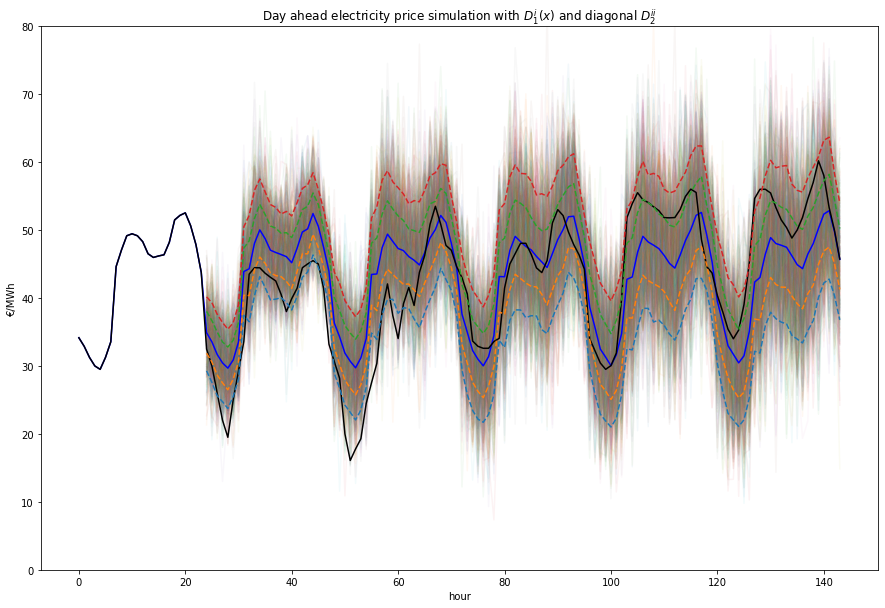

In [42]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_2.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="blue", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="black", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^{i}(x)$ and diagonal $D_2^{ii}$")
plt.show()

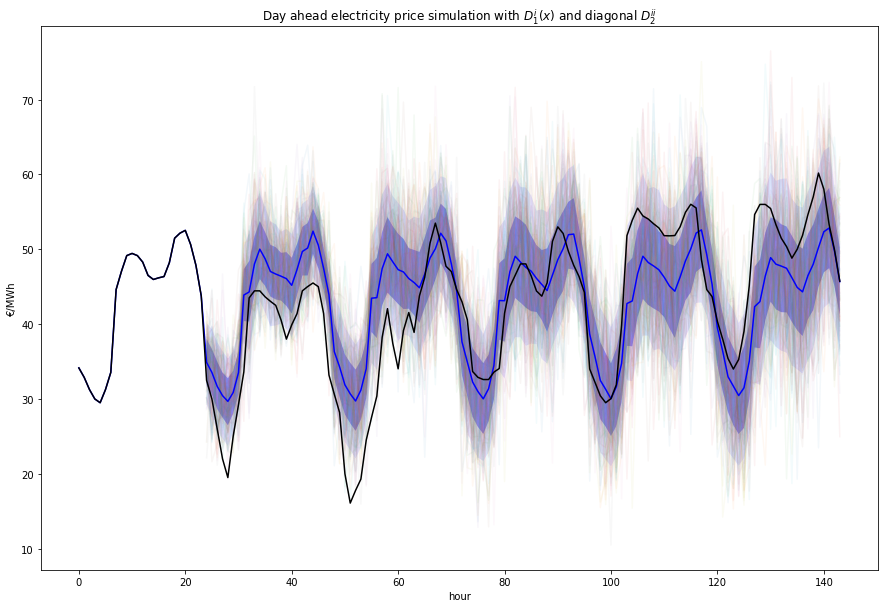

In [43]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=100, 
                title="Day ahead electricity price simulation with $D_1^{i}(x)$ and diagonal $D_2^{ii}$")

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$

In [44]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [45]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s.sqrt_diff_matrix))

em_3 = EulerMaruyama(num_sim=1000, periods=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=cte_diffusion)

In [46]:
sim_df = em_3.simulate(x0=x_0, random_seed=124)

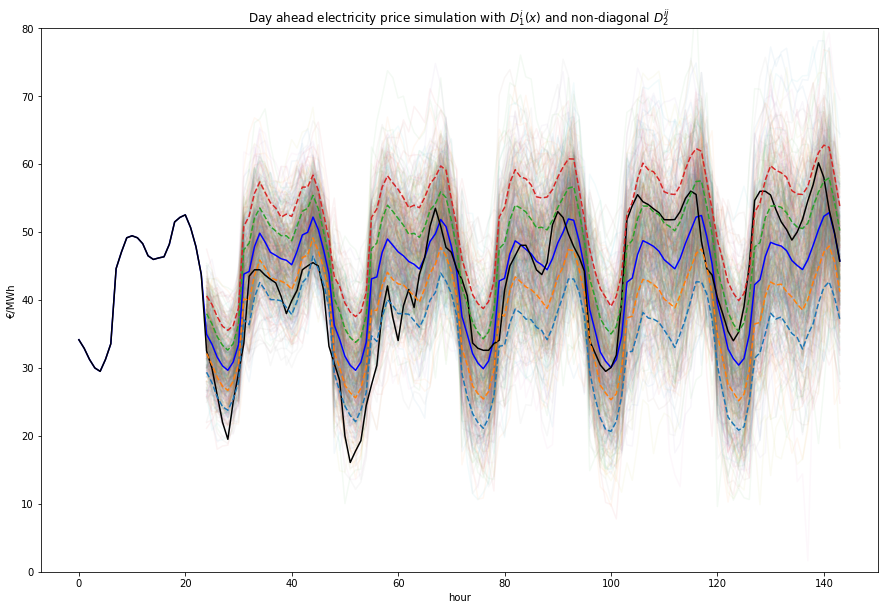

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_3.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="blue", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="black", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

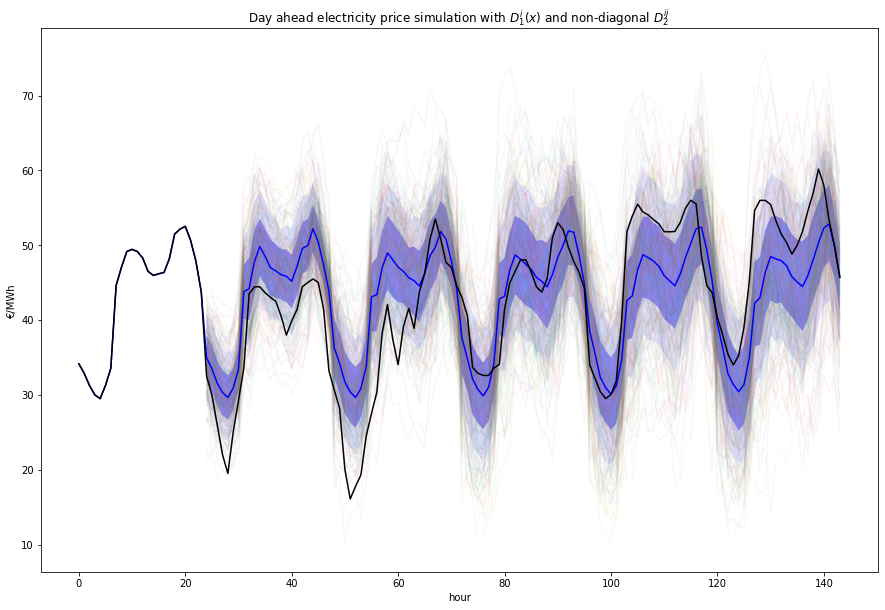

In [48]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=200,
               title="Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")

### Multivariate timeseries  - $D_{1}^{i}(X_{d}^i - X_{d-1}^i)$ 

In [49]:
s_back_drift = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, x_transformation="back_drift")

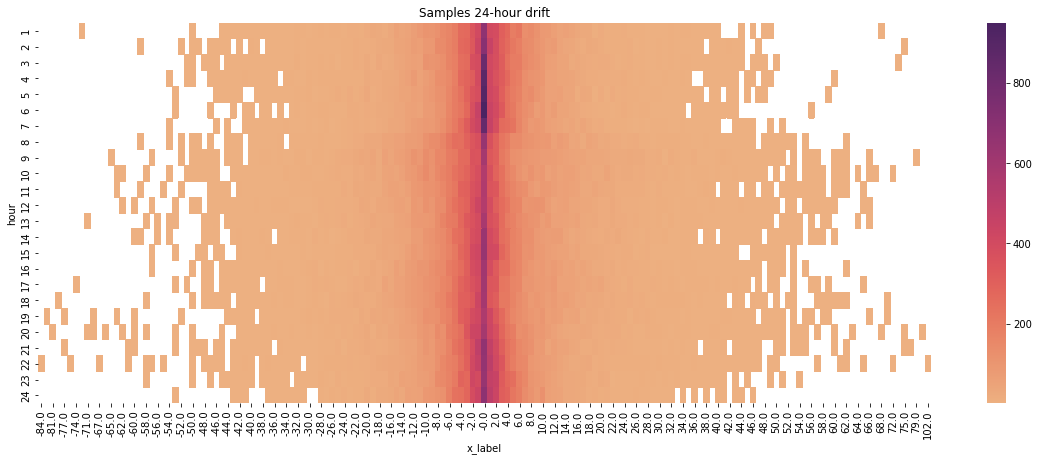

In [50]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.samples_hour_x.iloc[:, :200], ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Samples 24-hour drift")
fig.show()

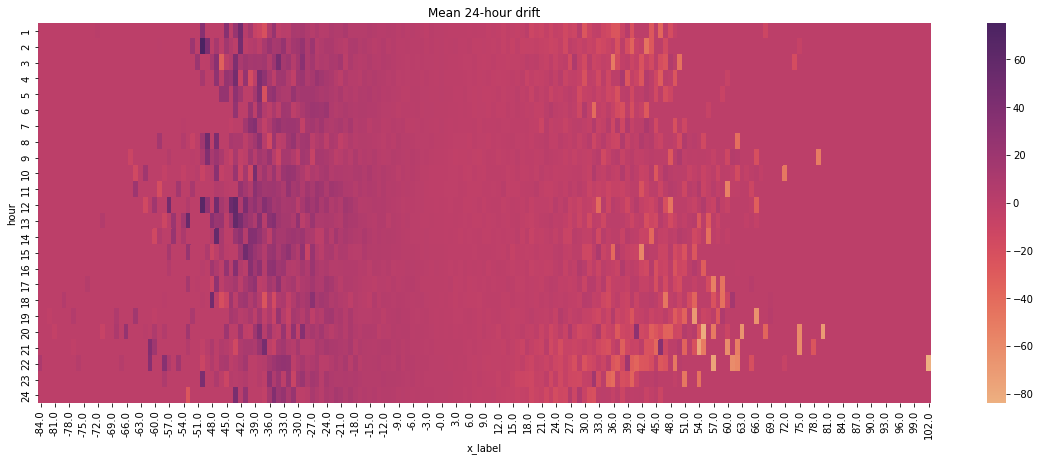

In [51]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.drift_hour_x, ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

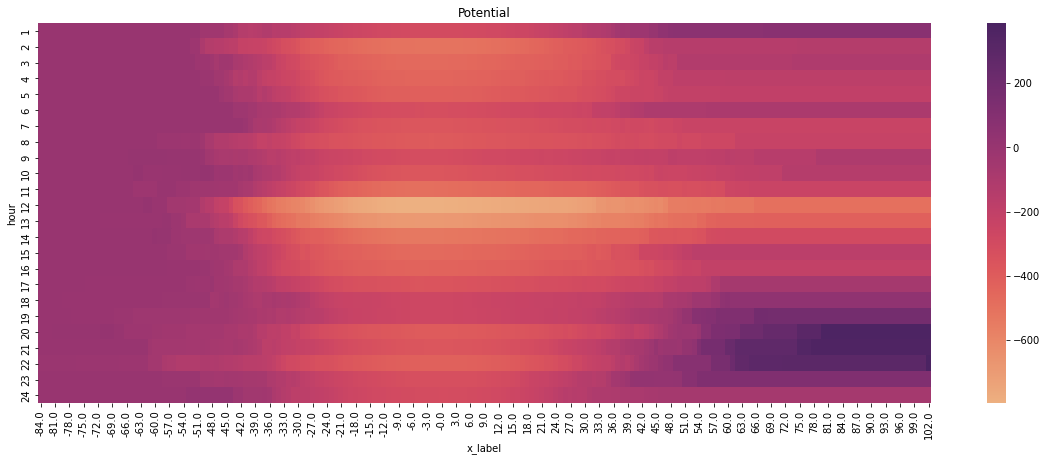

In [52]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.potential_hour_x, ax=ax, cmap='flare')
ax.set_title("Potential")
fig.show()

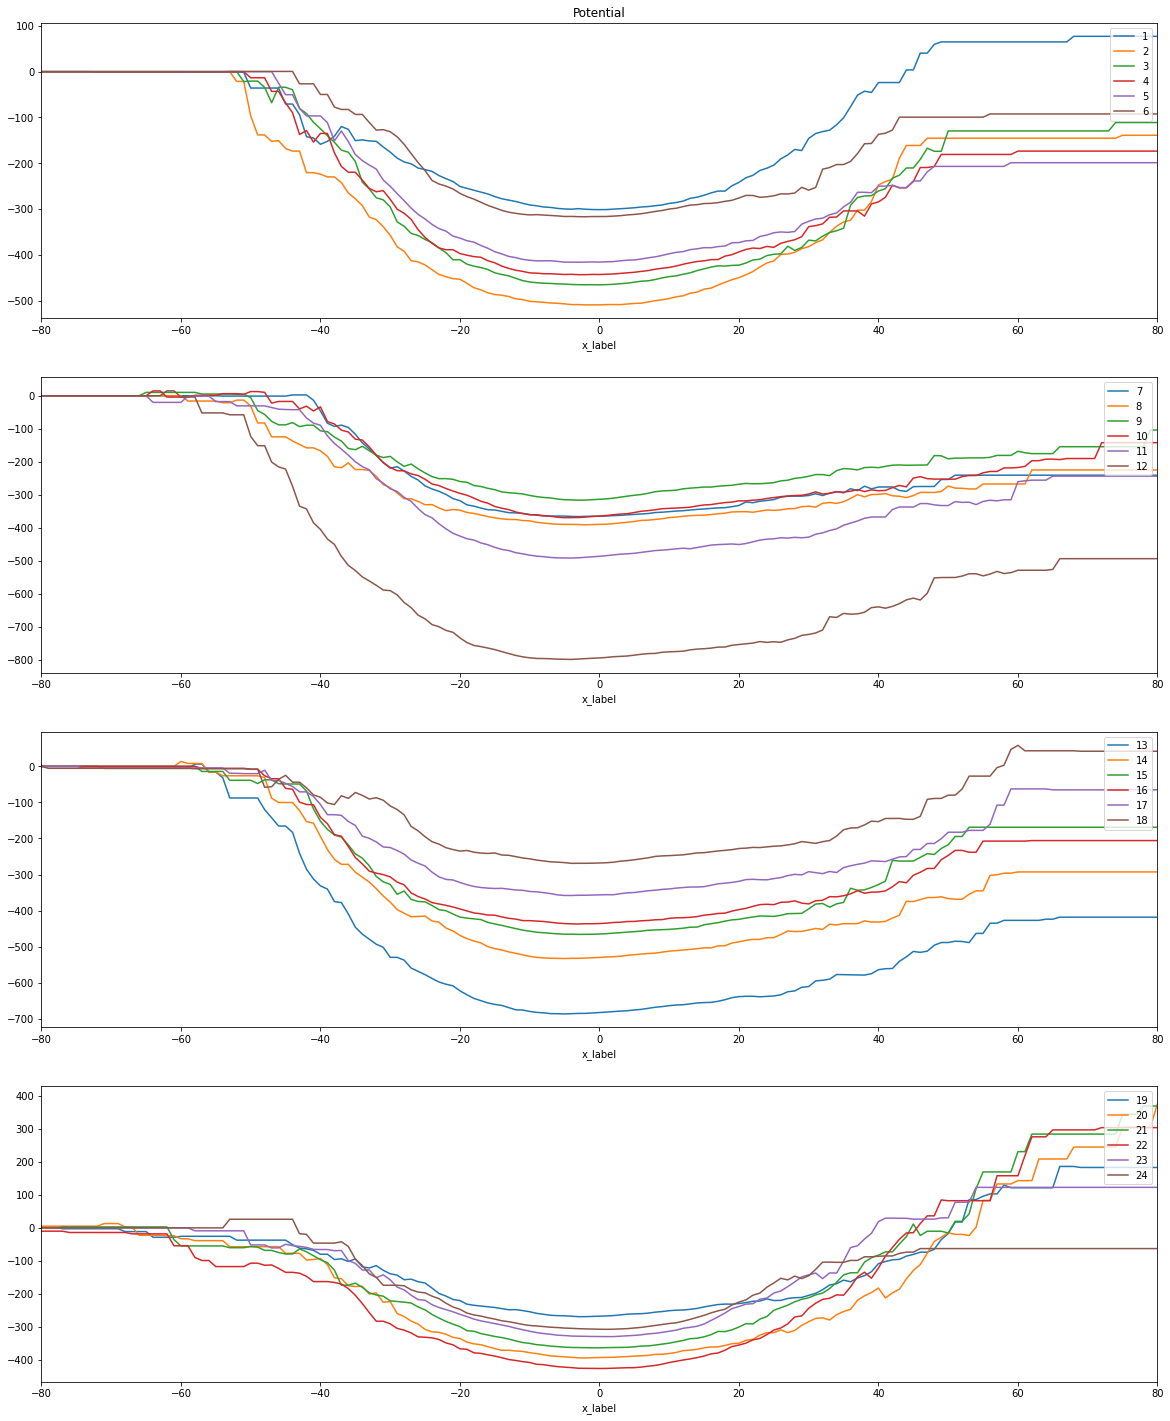

In [53]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s_back_drift.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(-80, 80)
    #ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

Text(0.1, 0.5, 'potential $[(€/MWh)^{2}/day]$')

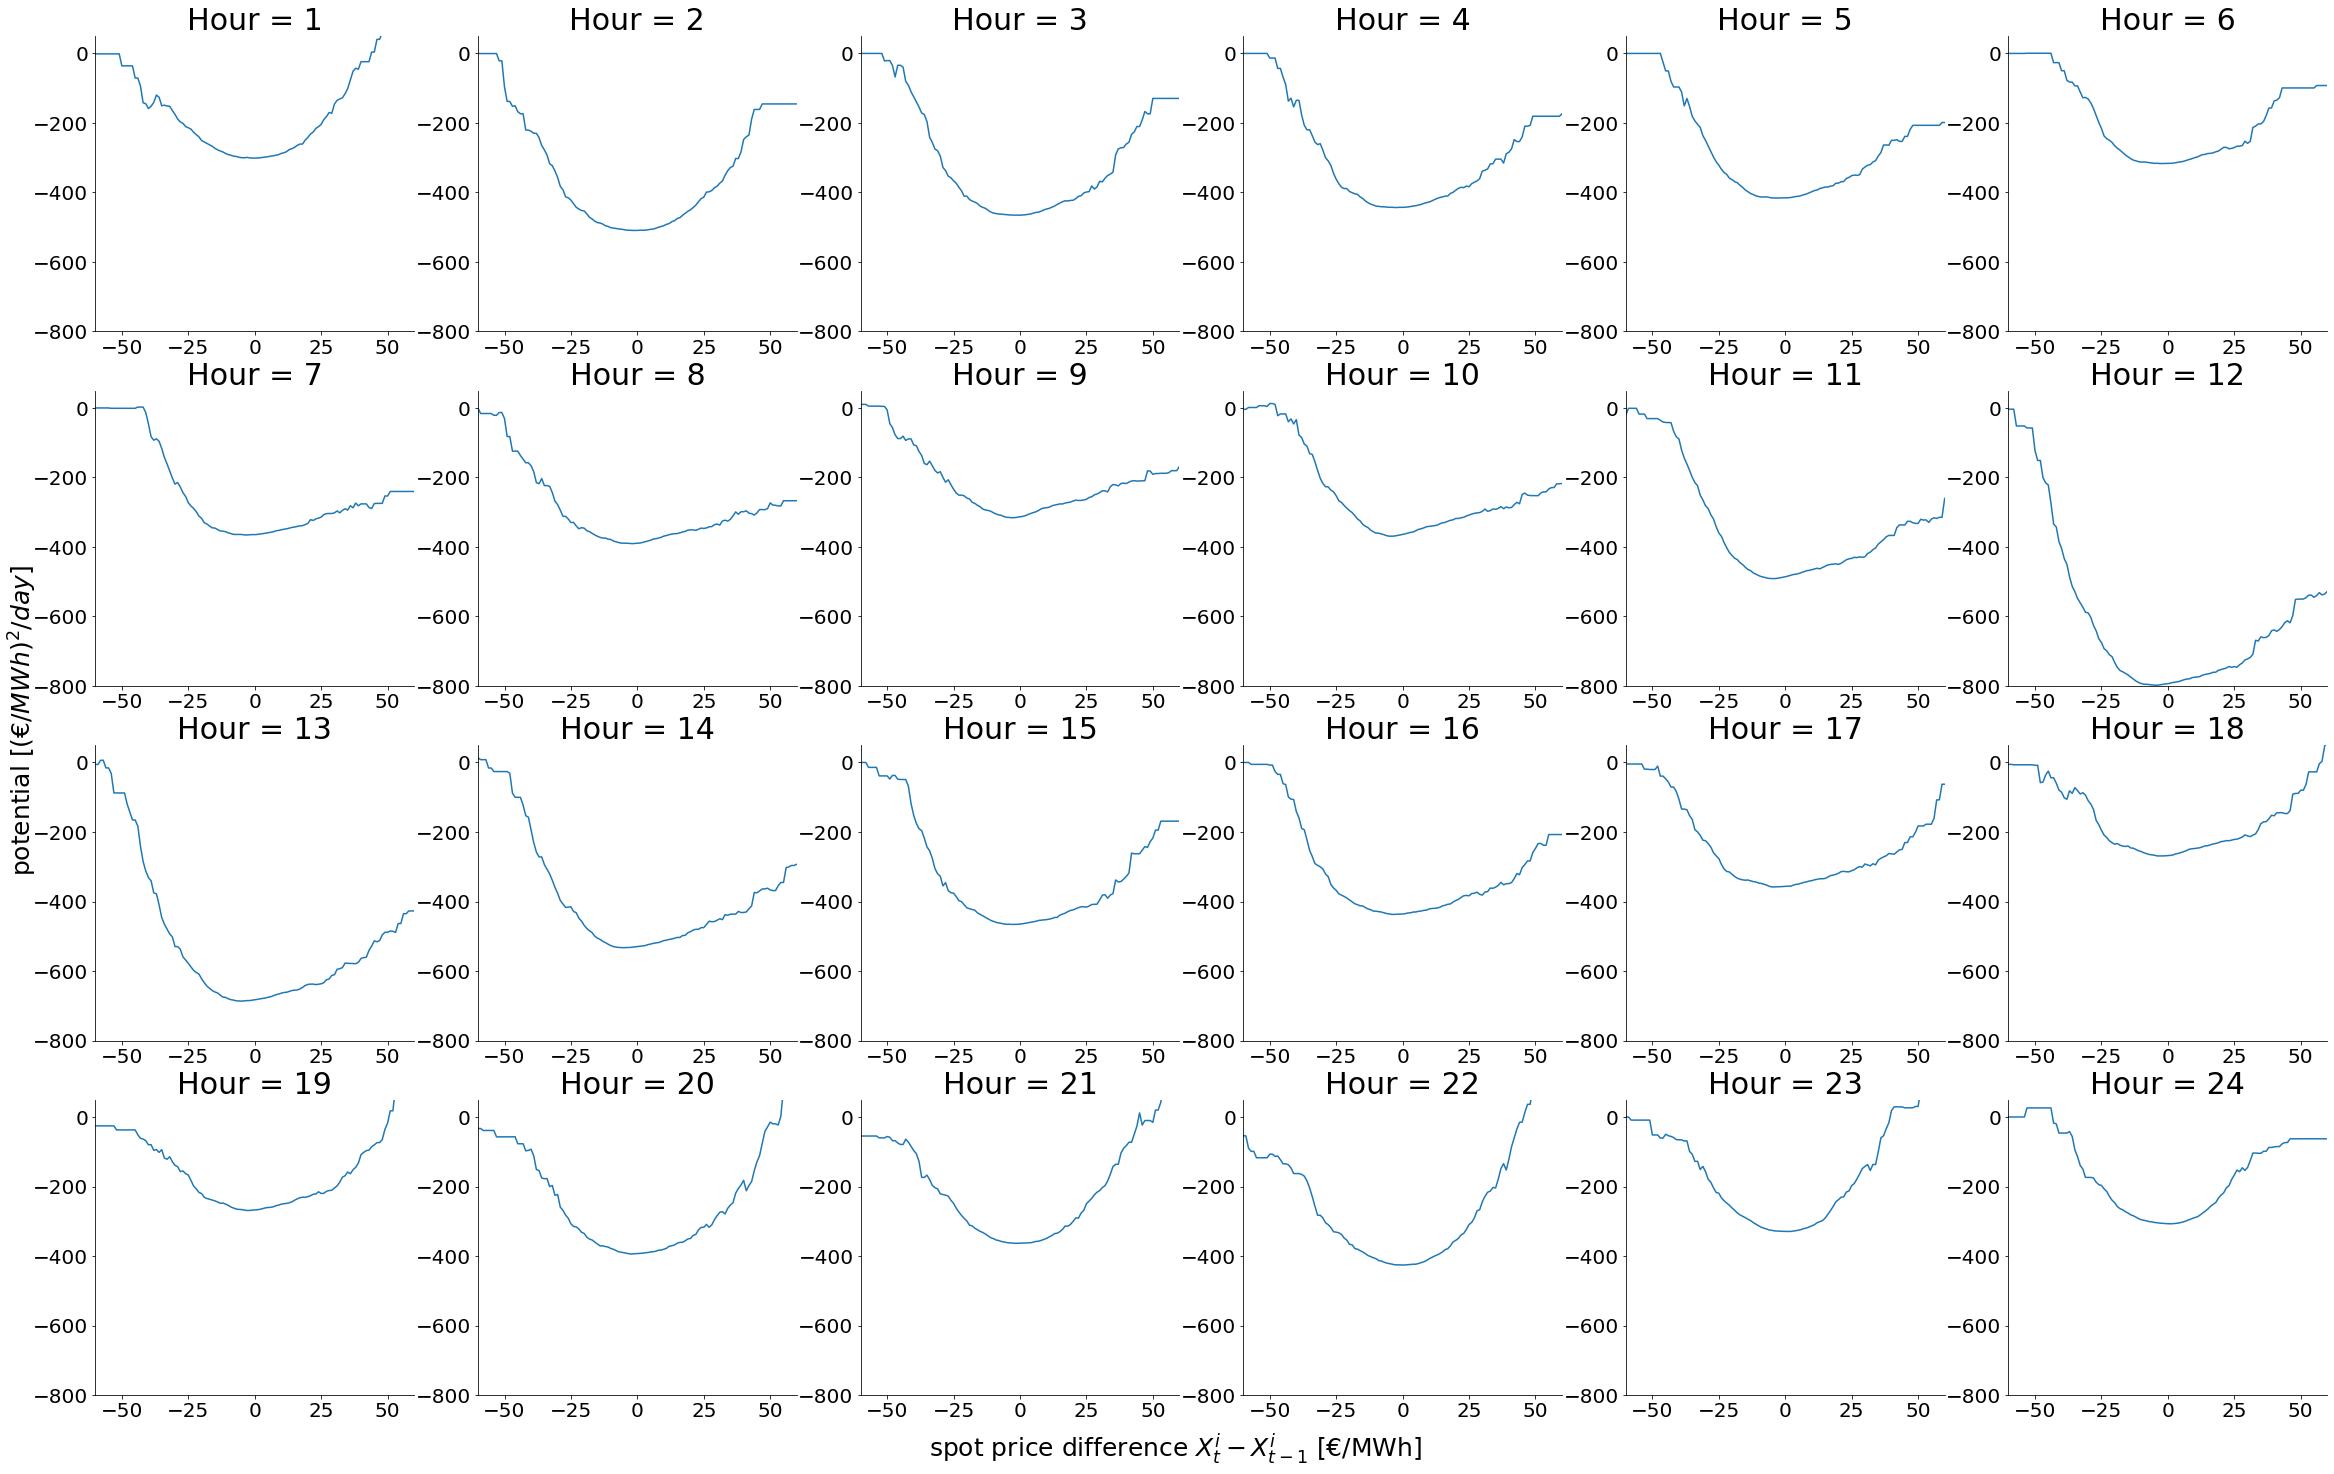

In [54]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s_back_drift.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(-60, 60)
        ax.set_ylim(-800, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price difference $X_{t}^{i} - X_{t-1}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

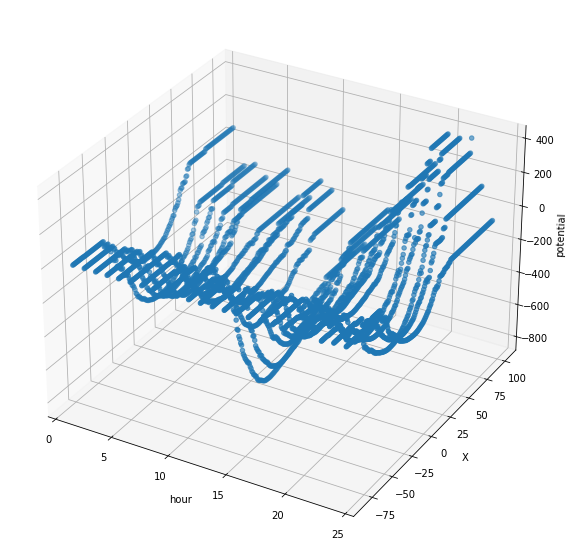

In [55]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s_back_drift.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

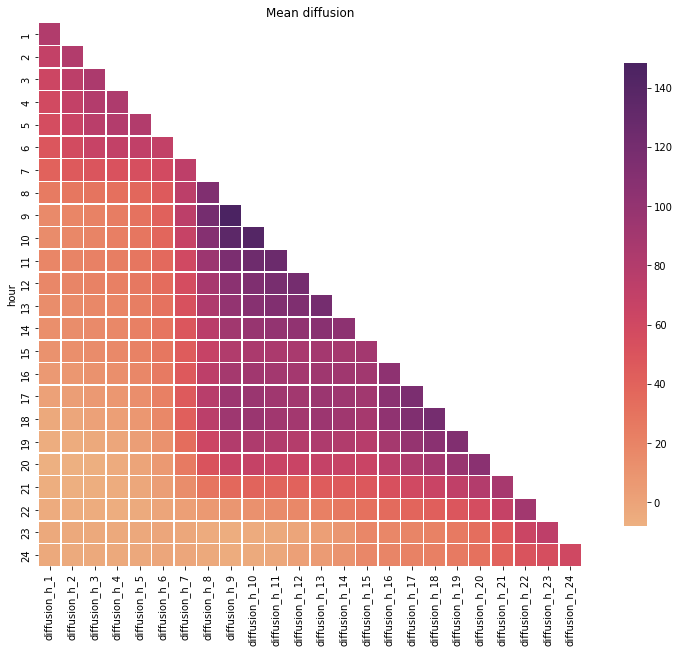

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s_back_drift.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s_back_drift.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^i(X_{d}^i - X_{d-1}^i)$ and non-diagonal constant $D_{2}^{ij}$

In [57]:
x_df = s_back_drift.df[(s_back_drift.df["date"] >= "2020-12-09")].iloc[:24*7]
t_0 = x_df["spain"].iloc[:24].values
t_1 = x_df["spain"].iloc[24:48].values
x_0 = np.vstack([t_0, t_1]).T

In [58]:
spatial_diff_drift = SpatialDifferenceDriftMultivariate(df=s_back_drift.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s_back_drift.sqrt_diff_matrix))

em_4 = EulerMaruyama(num_sim=1000, periods=7, delta_t=1, nu=0, drift=spatial_diff_drift, diffusion=cte_diffusion)

In [59]:
sim_df = em_4.simulate(x0=x_0, random_seed=124)

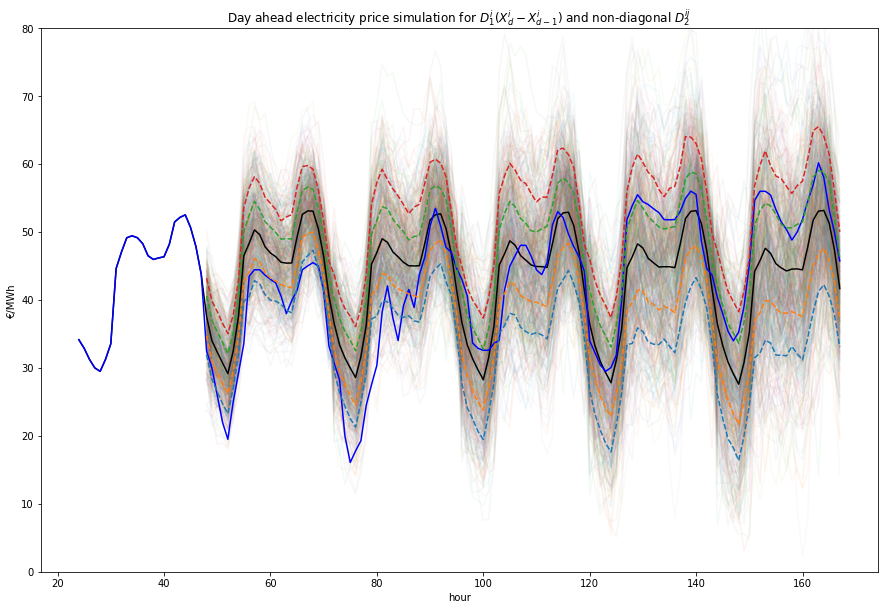

In [60]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[48:, : em_4.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).iloc[24:].plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].iloc[24:].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[48:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation for $D_1^i(X_d^i - X_{d-1}^i)$ and non-diagonal $D_2^{ij}$")
plt.show()

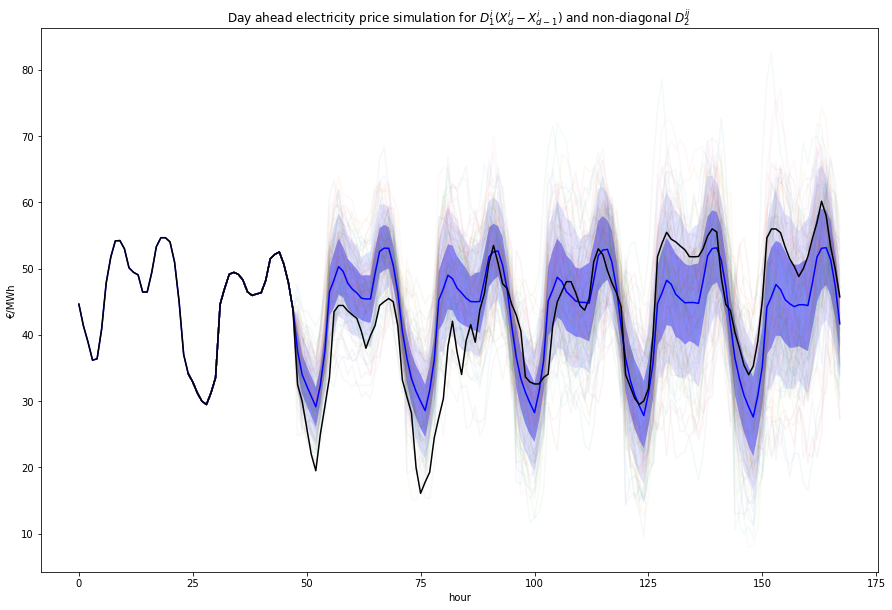

In [61]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=100,
               title="Day ahead electricity price simulation for $D_1^i(X_d^i - X_{d-1}^i)$ and non-diagonal $D_2^{ij}$")

## Gaussian kde

In [62]:
from matplotlib.lines import Line2D

In [63]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

In [64]:
def compute_historical_mean(df: pd.DataFrame, x_label_col_name: str, value_col_name: str):
    
    aux_df = df.copy(deep=True)
    aux_df[x_label_col_name] = aux_df[x_label_col_name].round(decimals=0)
    mean_x = aux_df.groupby(x_label_col_name)[value_col_name].mean()
    
    return mean_x

def plot_samples_kernel_mean_expected(ax: plt.axes, 
                                      gk: GaussianKernel, 
                                      historical_mean: pd.Series, 
                                      ymax_lim: float = None):

    ax.plot(gk.samples[0], gk.samples[1], 'k.', markersize=2, alpha=0.2)
    ax.plot(gk.expected_value_function[0, :], gk.expected_value_function[1, :], lw=2, color="blue")
    historical_mean.plot(ax=ax, lw=2, color="red")
    cs = ax.contourf(gk.grid[0], gk.grid[1], gk.p,
                     levels=100, cmap=plt.cm.gist_earth_r, alpha=0.7, antialiased=True)
    if ymax_lim:
        ax.set_ylim(0, ymax_lim)

def plot_potential(ax: plt.axis, gk: GaussianKernel, historical_mean: pd.Series):
    
    dx = gk.expected_value_function[0, 1] -  gk.expected_value_function[0, 0]
    ax.plot(gk.expected_value_function[0, :], (-1)*np.cumsum(gk.expected_value_function[1, :]*dx), color="blue")
    ax.plot(historical_mean.index, (-1)*np.cumsum(historical_mean.values), color="red")

$$D_1^{i}$$

In [65]:
%%time
d_1_dict = {}
d_1_historical_mean_dict = {}
for h in s_kde.df["hour"].unique():
    train_df = s_kde.df.query(f"hour == {h}")[["x_label", "drift_24"]].dropna()
    
    gk = GaussianKernel(samples=train_df, grid_shape=(1000, 1000), xmax=120, 
                        computation_mode=ComputationMode.Numba, mesh_chunks=8)
    historical_mean = compute_historical_mean(df=train_df, 
                                                x_label_col_name="x_label", 
                                                value_col_name="drift_24")
        
    d_1_dict[h] = gk
    d_1_historical_mean_dict[h] = historical_mean
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})
    
    plot_samples_kernel_mean_expected(ax=ax0, gk=gk, historical_mean=historical_mean)
    ax0.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax0.set_ylabel(f"spot price difference $X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}}$ [€/MWh]")
    ax0.set_title(f"Drift hour = {h}")
    ax0.set_xlim(0, 120)
    
    plot_potential(ax=ax1, gk=gk, historical_mean=historical_mean)
    ax1.set_title(f"Potential hour = {h}")
    ax1.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax1.set_ylabel(f"Potential")
    plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.8s


KeyboardInterrupt: 

In [ ]:
fig, axis = plt.subplots(6, 4, figsize=(25, 32))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*4+j
        plot_samples_kernel_mean_expected(ax=ax, gk=d_1_dict[h], historical_mean=d_1_historical_mean_dict[h])
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}")
        ax.set_xlim(0, 100)
        ax.set_ylim(-50, 50)

fig.text(0.5, 0.11, "spot price, $X_d^{h}$ [€/MWh]", ha="center", va="center", fontdict={"size": 20})
fig.text(0.1, 0.5, "spot price difference $X_{d+1}^{h} - X_{d}^{h}$ [€/MWh]", ha="center", va="center",
         fontdict={"size": 20}, rotation=90)

custom_lines = [Line2D([0], [0], color="red", lw=2, alpha=0.7),
                Line2D([0], [0], color="blue", lw=2)]
fig.legend(custom_lines, 
           ["Empirical mean spot price difference", "Expected spot price difference from Gaussian KDE"],
           ncol=2, loc = (0.2, 0.935), prop={"size": 18})
plt.show()

In [ ]:
for k,v in d_1_dict.items():
    with open(f"data/kde/d_1/d_1_{k}_1000_1000_coefficients.pkl", "wb") as f:
        pickle.dump(v, f)

In [66]:
d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)

$$ D_2^{ij} $$

#### Diagonal $D_2^{ij} \quad i=j$

In [ ]:
%%time
d_2_diag_dict = {}
d_2_diag_historical_mean_dict = {}
for h in range(1, 25):
    
    x_label_col_name = s_kde.x_col_name
    diff_col_name = s_kde.diffusion_cols[h-1]
    
    train_df = s_kde.df.query(f"hour == {h}")[[x_label_col_name, diff_col_name]].dropna()
    gk = GaussianKernel(samples=train_df, grid_shape=(100, 5000), ymin=-100)
    
    historical_mean = compute_historical_mean(df=train_df, 
                                              x_label_col_name=x_label_col_name, 
                                              value_col_name=diff_col_name)
    
    d_2_diag_dict[h] = gk
    d_2_diag_historical_mean_dict[h] = historical_mean
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_samples_kernel_mean_expected(
        ax=ax, gk=d_2_diag_dict_v2[h], 
        historical_mean=d_2_diag_historical_mean_dict[h], ymax_lim=historical_mean.max()
    )
    ax.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax.set_ylabel(f"Diffusion coefficient $(X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}})^2$ [$(€/MWh)^2$]")
    ax.set_title(f"Diffusion hour = {h}")
    plt.show()

In [ ]:
for k,v in d_2_diag_dict.items():
    with open(f"data/kde/d_2_diag/d_2_diag_{k}_1000_1000_coefficients.pkl", "wb") as f:
        pickle.dump(v, f)

In [67]:
d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)

#### Non-diagonal $D_2^{ij} \quad i \neq j$

In [ ]:
hour_i_list = []
hour_j_list = []
for i in np.arange(24, 1, -1):
    for j in range(i-1, 0, -1):
        hour_i_list.append(i)
        hour_j_list.append(j)

In [ ]:
def compute_diffusion_non_diagonal(vector_ts: VectorTimeSeries, hour_i: int, hour_j: int):
    
    x_label_col_name = vector_ts.x_col_name
    x_label_col_name_2 = vector_ts.x_two_col_names[hour_j-1]
    diff_col_name = vector_ts.diffusion_cols[hour_j-1] 
    
    train_df = vector_ts.df.query(f"hour == {hour_i}")[[x_label_col_name, x_label_col_name_2, diff_col_name]]
    train_df = train_df.dropna()
    
    gk = GaussianKernel(samples=train_df, grid_shape=(100, 100, 500), 
                        computation_mode=ComputationMode.Numba, 
                        mesh_chunks=8)
    return gk

In [68]:
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)

#### Drift coefficient

In [69]:
drift_df_list = []
hours = list(d_1_dict.keys())
hours.sort()
for h in hours:
    drift_df_list.append(
        pd.DataFrame(data={h: d_1_dict[h].expected_value_function[1, :]}).T
    )

expected_drift_kde_df = pd.concat(drift_df_list)
expected_drift_kde_df.columns = d_1_dict[hours[0]].expected_value_function[0, :]

In [70]:
expected_drift_kde_df.head()

0.000000    0.120120    0.240240    0.360360    0.480480    0.600601    \
1    9.484425    9.525034    9.566958    9.610155    9.654577    9.700170   
2    9.301392    9.294091    9.286891    9.279778    9.272738    9.265755   
3    8.817859    8.828810    8.840823    8.853920    8.868123    8.883453   
4    8.012234    8.021524    8.031663    8.042662    8.054533    8.067282   
5    7.457943    7.473693    7.490464    7.508271    7.527124    7.547033   

   0.720721    0.840841    0.960961    1.081081    ...  118.918919  \
1    9.746872    9.794615    9.843322    9.892910  ...  -27.968346   
2    9.258811    9.251885    9.244959    9.238008  ...  -49.243461   
3    8.899930    8.917572    8.936395    8.956412  ...  -48.197039   
4    8.080919    8.095447    8.110873    8.127196  ...  -47.615384   
5    7.568004    7.590044    7.613155    7.637339  ...  -31.496187   

   119.039039  119.159159  119.279279  119.399399  119.519520  119.639640  \
1  -27.989190  -28.010110  -28.031103  -28.052167  -28.073300  -28.094499   
2  -49.267834  -49.292207  -49.316580  -49.340952  -49.365324  -49.389697   
3  -48.215190  -48.233247  -48.251213  -48.269085  -48.286864  -48.304549   
4  -47.642165  -47.668905  -47.695603  -47.722260  -47.748875  -47.775449   
5  -31.521001  -31.545815  -31.570629  -31.595443  -31.620257  -31.645071   

   119.759760  119.879880  120.000000  
1  -28.115763  -28.137088  -28.158475  
2  -49.414068  -49.438440  -49.462812  
3  -48.322141  -48.339639  -48.357043  
4  -47.801983  -47.828477  -47.854931  
5  -31.669885  -31.694699  -31.719513  

[5 rows x 1000 columns]

In [71]:
x0 = s_kde.df.iloc[-48:-24]["x_label"].values

In [72]:
x0

array([43.84, 40.43, 36.75, 34.31, 33.5 , 36.03, 43.31, 49.52, 53.01,
       55.6 , 55.68, 53.7 , 51.86, 52.01, 50.45, 50.27, 52.36, 54.96,
       59.96, 59.86, 56.5 , 52.95, 51.13, 47.64])

In [73]:
drift = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

In [74]:
x = np.zeros((24, 1000))

In [75]:
x[:, 0] = x0

In [76]:
drift.get_value(x=x, t=1)

array([ 0.03050127, -0.17214051, -0.34440095, -0.30941537, -0.31967546,
       -0.34562403, -0.78527469, -1.75056126, -2.4469215 , -2.36413228,
       -1.82929016, -1.1895412 , -0.66420165, -0.69957929, -0.88119188,
       -1.07927951, -1.52517821, -2.05339017, -2.34943505, -1.47772964,
       -0.60740667,  0.27891975,  0.13988042, -0.05542836])

#### Diffusion matrix

In [77]:
# fill diffusion matrix
diff_matrix_kde = np.zeros((24, 24))

for k, v in d_2_non_diag_dict.items():
    for k_j, v_j in v.items():
        diff_matrix_kde[k-1, k_j -1] = v_j.expected_value

diff_matrix_kde = diff_matrix_kde + np.tril(diff_matrix_kde, k=-1).T

for k, v in d_2_diag_dict.items():
    diff_matrix_kde[k-1][k-1] = v.expected_value

In [78]:
np.linalg.eigvals(diff_matrix_kde)

array([ 1.05222599e+03,  3.92268209e+02,  2.14847920e+02,  1.00638054e+02,
        7.29640753e+01,  5.39267131e+01, -1.54792207e+01,  4.87363678e+01,
       -7.65727455e+00,  4.08188532e+01, -5.03574657e-01,  2.77388159e+00,
        3.89129258e+00,  2.95961133e+01,  8.90565505e+00,  1.20850412e+01,
        1.35800360e+01,  1.26991813e+01,  2.63111172e+01,  1.96315430e+01,
        1.90601429e+01,  2.10964899e+01,  2.34198943e+01,  2.27780245e+01])

In [79]:
from statsmodels.stats.correlation_tools import cov_nearest

In [80]:
nearest_diff_matrix_kde = cov_nearest(cov=diff_matrix_kde, threshold=1e-14)

In [81]:
np.max(nearest_diff_matrix_kde - diff_matrix_kde)

0.35136540220598533

In [82]:
np.linalg.eigvals(nearest_diff_matrix_kde)

array([1.04526382e+03, 3.82303116e+02, 2.12225740e+02, 9.94795520e+01,
       7.25999337e+01, 5.36465453e+01, 4.75313777e+01, 4.05603409e+01,
       2.95792997e+01, 2.75767512e+00, 3.87206901e+00, 2.62411745e+01,
       2.33190020e+01, 2.27439743e+01, 2.08991042e+01, 1.93853465e+01,
       1.90529257e+01, 8.86152470e+00, 1.35705309e+01, 1.20416372e+01,
       1.26798299e+01, 6.60566364e-13, 1.18178781e-12, 1.03392108e-12])

In [83]:
from scipy.linalg import sqrtm

In [84]:
sqrt_diff_matrix_kde = sqrtm(nearest_diff_matrix_kde)

In [85]:
diff = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

In [86]:
diff.get_value(x=np.array([]), t=24)

array([[ 7.21076880e+00,  3.02966443e+00,  1.71146154e+00,
         1.45467695e+00,  1.36820069e+00,  1.40526957e+00,
         1.27071255e+00,  6.61804206e-01,  2.30469023e-01,
         3.68296485e-01,  5.09047779e-01,  4.90802576e-01,
         3.11081341e-01,  3.22204165e-01,  2.51584129e-01,
         5.29985123e-02, -1.27846122e-01, -2.18826141e-01,
        -2.19777087e-01, -3.21177982e-01, -2.39236601e-01,
         2.30660724e-02,  6.42478909e-02,  1.55177348e-01],
       [ 3.02966443e+00,  5.97416289e+00,  3.83111644e+00,
         2.04337440e+00,  1.42301416e+00,  1.66421724e+00,
         1.43840028e+00,  5.99555796e-01,  2.90434954e-01,
         3.67304340e-01,  4.24691335e-01,  4.10463810e-01,
         2.87971137e-01,  2.56606208e-01,  2.68954642e-01,
         9.94496853e-02, -3.73949325e-02, -2.12423492e-01,
        -2.86248286e-01, -3.33060328e-01, -2.28428683e-01,
        -9.46623550e-02, -2.52430255e-02,  4.06442432e-02],
       [ 1.71146154e+00,  3.83111644e+00,  5.83466730e

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$

In [87]:
x_df = s_kde.df[(s_kde.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [88]:
drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

em_5 = EulerMaruyama(num_sim=10000, periods=6, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

In [89]:
%%time
sim_df = em_5.simulate(x0=x_0, random_seed=124)

CPU times: user 17.8 s, sys: 22.5 ms, total: 17.8 s
Wall time: 17.8 s


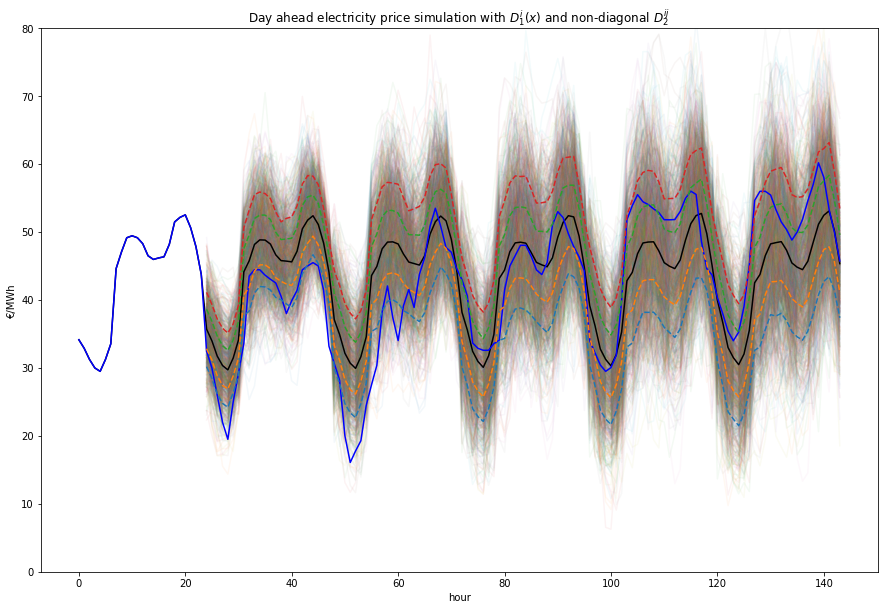

In [91]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_5.num_sim//8].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

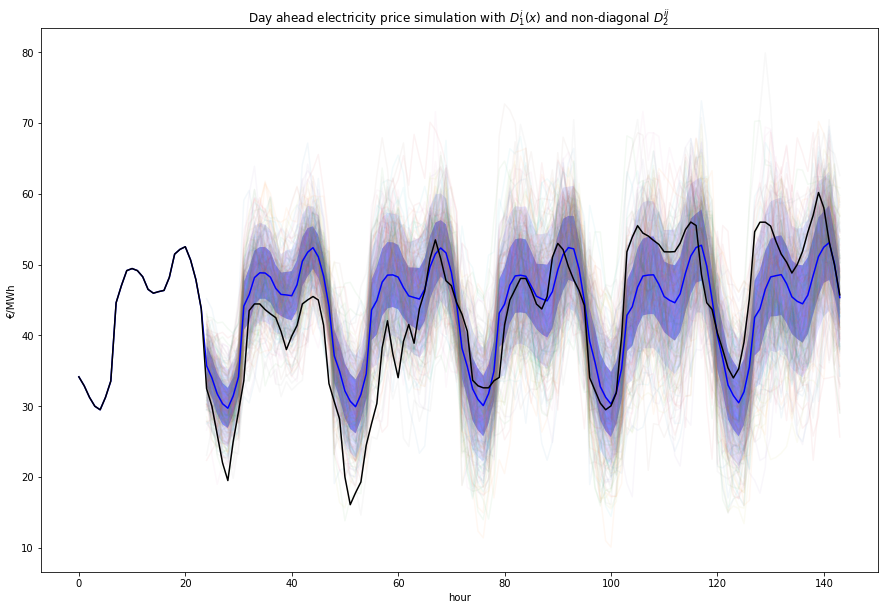

In [94]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=200,
               title="Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$ - higher time resolution

Doubt: Drift and diffusion were computed with d+1 - d step. Interaction with higher time resolution. 

In [95]:
drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

em_6 = EulerMaruyama(num_sim=1000, periods=501, delta_t=0.01, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

In [96]:
%%time
sim_df = em_6.simulate(x0=x_0, random_seed=124)

CPU times: user 2min 11s, sys: 915 ms, total: 2min 12s
Wall time: 2min 12s


In [97]:
indexes = []
dim = x_0.shape[0]
for i in np.arange((em_6.periods-1)*em_6.delta_t + 1):
    indexes += list(np.arange(int(i*dim*(1/em_6.delta_t)), int(i*dim*(1/em_6.delta_t)+dim)))

In [98]:
sim_df = sim_df.loc[indexes].reset_index().iloc[:, 1:]

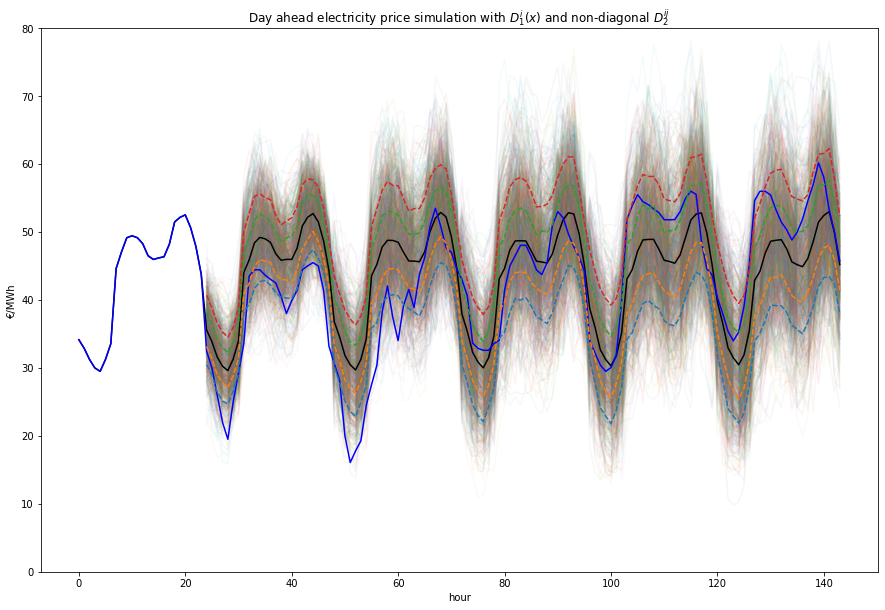

In [99]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_5.num_sim//4].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

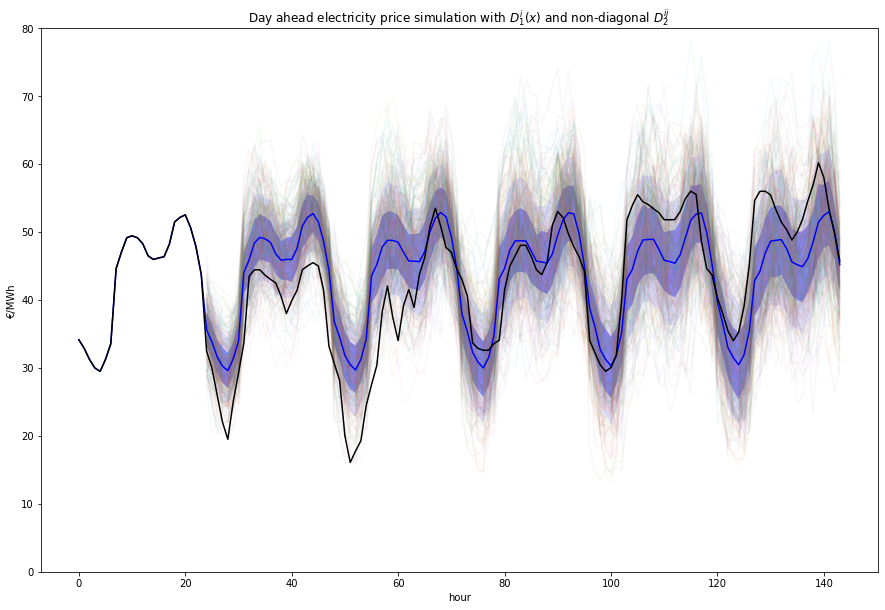

In [102]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=250, ymax=80,
               title="Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")

Compute price inflation as mean daily prices - mean drfit and learn this through a neural ODE